# Linear fit between two device's clocks

This approach is used in scenario when you have two devices with potentially uncalibrated clocks. And you need to measure elapsed time as much faithfully as possible using both local and remote device clocks. Remote device clock events can be received asynchronously by local device, so there can be some random delay. Such scenario is very suitable for use with Bluetooth Rubik's Cubes which can measure solve time by their internal clock, but such clock may be very uncalibrated and introduce significant time skew.

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import pandas as pd
import scipy.stats as st
import random as rnd

In [2]:
def tsLinearFit(tsList, inv=False):
    sumX = 0
    sumY = 0
    sumXY = 0
    sumXX = 0
    sumYY = 0
    n = 0
    for i in range(len(tsList)):
        x = tsList[i][2 if inv else 1]
        y = tsList[i][1 if inv else 2]
        if x is None or y is None:
            continue
        n += 1
        sumX += x
        sumY += y
        sumXY += x * y
        sumXX += x * x
        sumYY += y * y
    varY = n * sumYY - sumY * sumY
    varX = n * sumXX - sumX * sumX
    covXY = n * sumXY - sumX * sumY
    slope = 1 if varX < 1e-3 else covXY / varX
    intercept = 0 if n < 1 else sumY / n - slope * sumX / n
    return [slope, intercept]

slope = 1.027013119455514, intercept = 3656.7754304383634


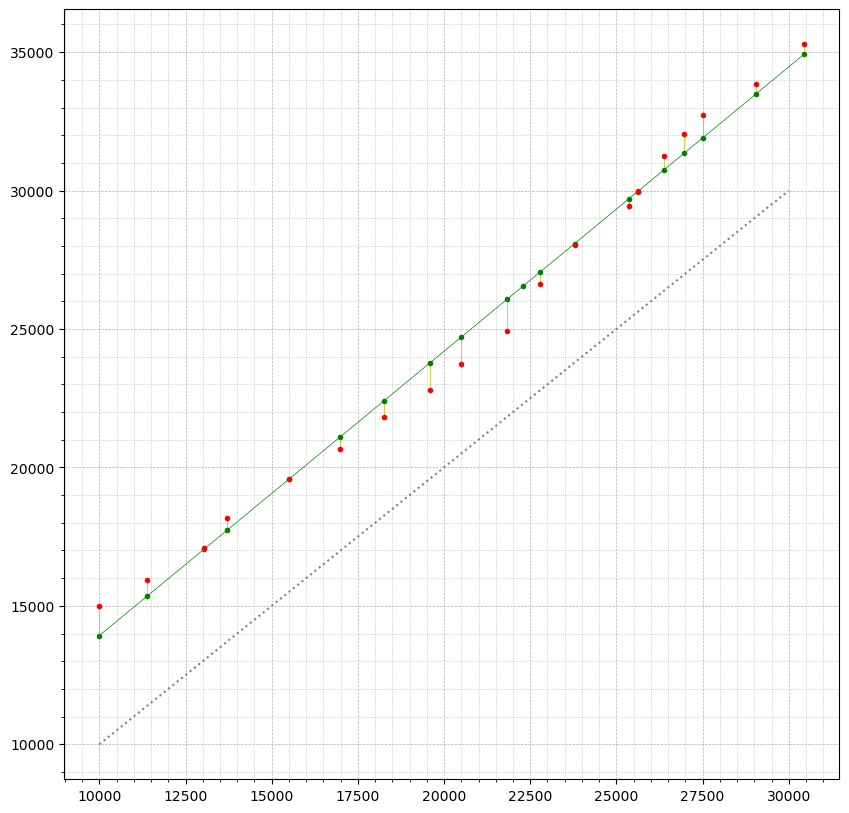

In [3]:

fig, ax = plt.subplots(figsize=(10,10),dpi=100)
ax.grid(which='minor',linestyle=':',linewidth=0.5)
ax.grid(which='major',linestyle='--',linewidth=0.5)
ax.minorticks_on()

# Generate sample data with timestamps
rnd.seed(0xDEAD)
n = 20
X = np.arange(0, n, dtype=int)
DT = np.zeros(n, dtype=object) # device ts list
LT = np.zeros(n, dtype=object) # local ts list
DT[0] = 10000
LT[0] = DT[0] + 5000 # time skew between timelines not affect slope and fitted intervals
for x in X:
    if x > 0:
        r = rnd.randint(500, 1500)                     # random time interval
        DT[x] = DT[x-1] + r + rnd.randint(-500, 500)   # device ts with random error
        LT[x] = LT[x-1] + r                            # local ts
LT[10] = None; # missed move local ts
tsList = np.column_stack((X, DT, LT))

# baseline slope
ax.plot([10000,30000],[10000,30000], ls=':', c='gray')

slope, intercept = tsLinearFit(tsList)
print(f"slope = {slope}, intercept = {intercept}")

ax.plot(DT, LT, 'r.', zorder=4)
ax.plot(DT, slope * DT + intercept, 'g.', zorder=3)
ax.plot(DT, slope * DT + intercept, 'g-', lw=0.5, zorder=2)

for x in X:
    ax.add_line(lines.Line2D((DT[x], DT[x]),(LT[x], slope * DT[x] + intercept), lw=0.5, color='y', zorder=1))

plt.draw()


In [4]:
first = round(slope * tsList[0][1] + intercept)
tsFitted = np.copy(tsList)

for i in range(len(tsFitted)):
    tsFitted[i][1] = round(slope * tsFitted[i][1] + intercept) - first;

tsListDF = pd.DataFrame(tsList, columns=["N", "DEVICE_TS", "LOCAL_TS"])
tsFittedDF = pd.DataFrame(tsFitted, columns=["N", "DEVICE_TS", "LOCAL_TS"])
joinedDF = tsListDF.join(tsFittedDF, on='N', lsuffix='_RAW', rsuffix='_FIT')
display(joinedDF[['DEVICE_TS_RAW','LOCAL_TS_RAW', 'DEVICE_TS_FIT']])

,DEVICE_TS_RAW,LOCAL_TS_RAW,DEVICE_TS_FIT
0,10000,15000,0
1,11379,15922,1416
2,13036,17083,3118
3,13713,18179,3813
4,15499,19581,5647
5,16970,20648,7158
6,18250,21804,8473
7,19594,22779,9853
8,20487,23727,10770
9,21823,24917,12142
